<a href="https://www.kaggle.com/code/boshili/tabular-playground-series-apr-2022-use-lstm?scriptVersionId=93495169" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

This note is inspired form [tps_apr_lstms_220417](https://www.kaggle.com/code/zhixx018/tps-apr-lstms-220417) and [TPSApr22 - FE + Pseudo Labels + Bi-LSTM](https://www.kaggle.com/code/hasanbasriakcay/tpsapr22-fe-pseudo-labels-bi-lstm)

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import matplotlib

In [2]:
train = pd.read_csv('../input/tabular-playground-series-apr-2022/train.csv')
train_labels = pd.read_csv('../input/tabular-playground-series-apr-2022/train_labels.csv')
test = pd.read_csv('../input/tabular-playground-series-apr-2022/test.csv')

## Fetaure Engineering

In [3]:
def add_lag_features(df):

    sensors = ['sensor_'+'%02d'%i for i in range(0, 13)]
    for sensor in sensors:
        df[sensor + '_lag1'] = df.groupby('sequence')[sensor].shift(1)
        df.fillna(0, inplace=True)
        df[sensor + '_diff1'] = df[sensor] - df[sensor + '_lag1']

    return df

In [4]:
train = add_lag_features(train)
test = add_lag_features(test)

In [5]:
groups = train['sequence']

In [6]:
Window = 60
y = train_labels['state'].to_numpy()
train.drop(["sequence","step","subject"], axis=1, inplace=True)
test.drop(["sequence","step","subject"], axis=1, inplace=True)

In [7]:
train

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_08_lag1,sensor_08_diff1,sensor_09_lag1,sensor_09_diff1,sensor_10_lag1,sensor_10_diff1,sensor_11_lag1,sensor_11_diff1,sensor_12_lag1,sensor_12_diff1
0,-0.196291,0.112395,1.000000,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,...,0.0,-0.1,0.000000,-0.963873,0.000000,-0.985069,0.000000,0.531893,0.000000,4.751492
1,-0.447450,0.134454,1.000000,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,...,-0.1,0.3,-0.963873,0.662572,-0.985069,1.067802,0.531893,-0.763374,4.751492,-4.297101
2,0.326893,-0.694328,1.000000,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,...,0.2,1.2,-0.301301,1.303468,0.082733,0.366488,-0.231481,-0.354938,0.454390,-5.190537
3,0.523184,0.751050,1.000000,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,...,1.4,-1.7,1.002168,-1.997832,0.449221,-0.883512,-0.586420,1.931070,-4.736147,5.165388
4,0.272025,1.074580,1.000000,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,...,-0.3,-0.6,-0.995665,2.051301,-0.434290,1.246921,1.344650,-1.221193,0.429241,-0.652600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558075,-0.282844,-1.217437,-1.666153,0.586726,-0.930698,-0.451010,-0.651184,0.368702,0.4,0.008671,...,-1.2,1.6,-0.647399,0.656069,-0.596996,-0.126540,-0.728395,0.374486,0.639812,-1.554561
1558076,0.130603,0.349790,-1.666153,-0.324779,0.775324,-0.332835,0.099271,0.122137,-0.2,0.644509,...,0.4,-0.6,0.008671,0.635838,-0.723536,1.414943,-0.353909,-0.259259,-0.914749,0.398977
1558077,-0.579598,0.429622,-1.666153,0.319469,0.308861,0.282723,-0.512750,0.012214,-1.6,-0.424133,...,-0.2,-1.4,0.644509,-1.068642,0.691407,0.025447,-0.613169,2.241770,-0.515772,1.444160
1558078,1.278980,1.711134,-1.522820,0.802655,-0.460541,-0.055348,2.405282,0.043511,1.9,0.283960,...,-1.6,3.5,-0.424133,0.708092,0.716855,-1.631769,1.628601,-1.264403,0.928389,-0.716965


## Normalize Data

In [8]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(train)
X_train = sc.transform(train)
X_test = sc.transform(test)

## Reshape Data

set 60 row in one sequence

In [9]:
y_train = y.copy()
X_train = X_train.reshape(-1, Window, X_train.shape[-1])
X_test = X_test.reshape(-1, Window, X_test.shape[-1])

In [10]:
print(y_train.shape, X_train.shape, X_test.shape)

(25968,) (25968, 60, 39) (12218, 60, 39)


## Build Bidirectional Model

In [11]:
from keras import Model
from keras.layers import *
from keras.callbacks import *
from keras.metrics import AUC

In [12]:
def get_model():

    x_input = Input(shape=X_train.shape[1:])

    x1 = Bidirectional(LSTM(units=512, return_sequences=True))(x_input)
    x2 = Bidirectional(LSTM(units=256, return_sequences=True))(x1)

    z2 = Bidirectional(LSTM(units=512, return_sequences=True))(x_input)
    z3 = Bidirectional(LSTM(units=256, return_sequences=True))(z2)
    c = Concatenate(axis=2)([x2, z3])

    x3 = Bidirectional(LSTM(units=128, return_sequences=True))(c)

    x4 = GlobalMaxPooling1D()(x3)
    x5 = Dense(units=128, activation='selu')(x4)
    x_output = Dense(1, activation='sigmoid')(x5)

    model = Model(inputs=x_input, outputs=x_output, name='Bi-Lstm')

    model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=[AUC(name = 'auc')])
    return  model


model = get_model()
model.summary()

2022-04-20 03:55:05.305506: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 03:55:05.390255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 03:55:05.391142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 03:55:05.392288: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "Bi-Lstm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 39)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 60, 1024)     2260992     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 60, 1024)     2260992     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 60, 512)      2623488     bidirectional[0][0]              
____________________________________________________________________________________________

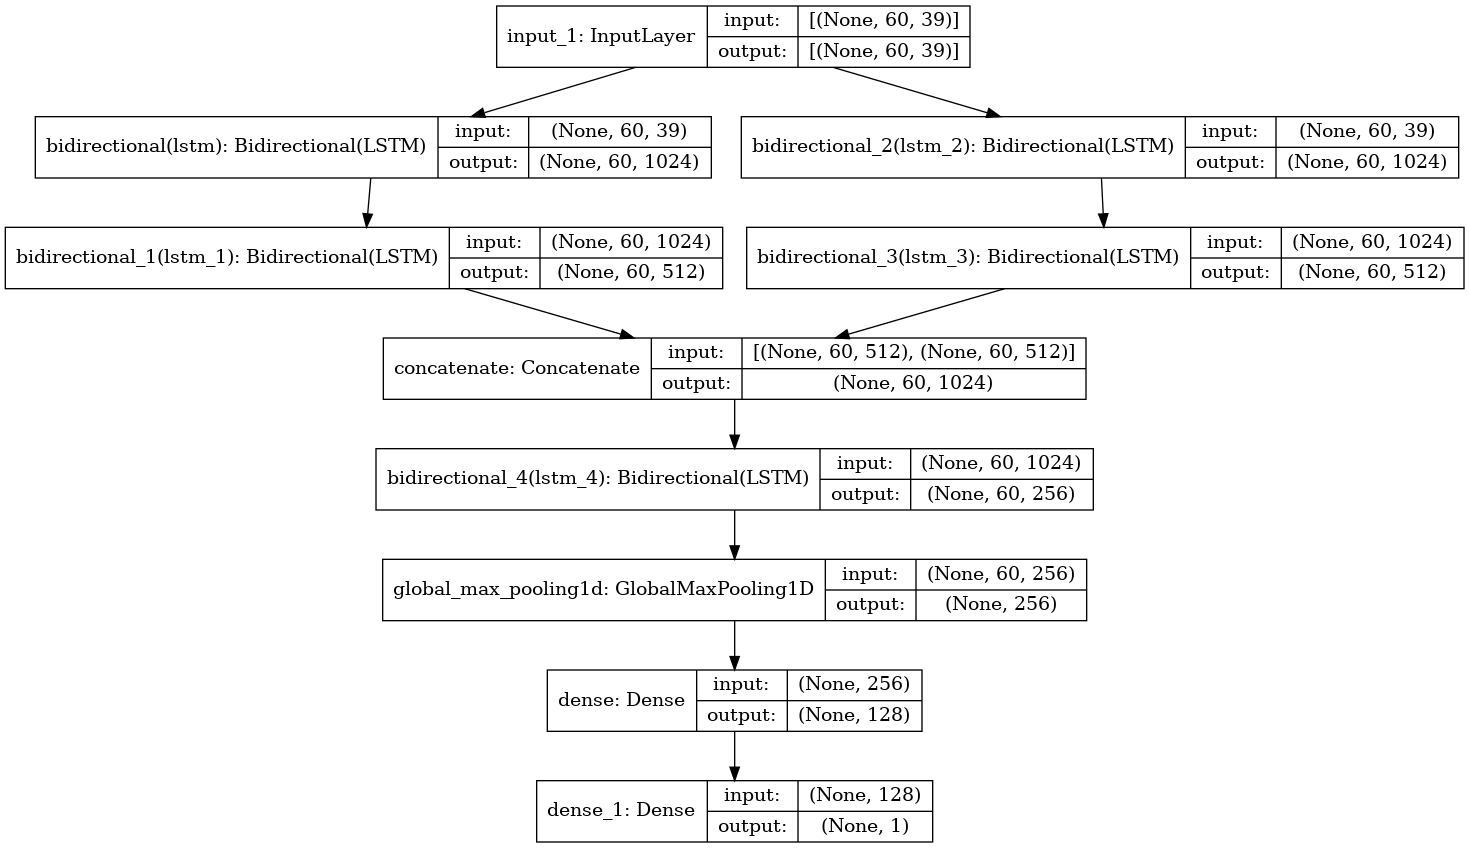

In [13]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

## Fit Model

In [14]:
def plot_hist(hist, metric='auc', ax=None, fold=0):
    if ax==None:
        plt.plot(hist.history[metric])
        plt.plot(hist.history["val_" + metric])
        plt.title(f"model performance fold {fold}")
        plt.ylabel("area_under_curve")
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], loc="upper left")
        plt.show()
        return
    else:
        ax.plot(hist.history[metric])
        ax.plot(hist.history["val_" + metric])
        ax.set_title(f"model performance fold {fold}")
        ax.set_ylabel("area_under_curve")
        ax.set_xlabel("epoch")
        ax.legend(["train", "validation"], loc="upper left")

## Use K-Fold for corss validation

Fold: 1 

2022-04-20 03:55:15.099223: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-20 03:55:27.219724: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


auc: 0.95713
Fold: 2 auc: 0.96684
Fold: 3 auc: 0.96908
Fold: 4 auc: 0.96948
Fold: 5 auc: 0.96634
Fold: 6 auc: 0.97479
Fold: 7 auc: 0.97331
Fold: 8 auc: 0.96698
Fold: 9 auc: 0.96937
Fold: 10 auc: 0.96807


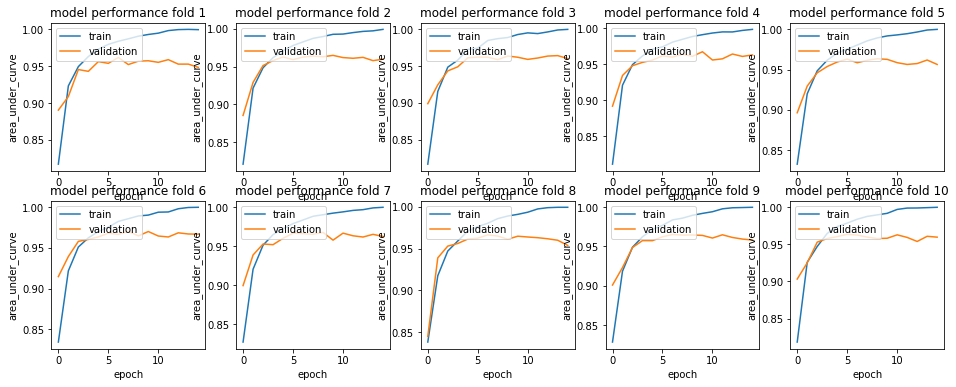

In [15]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import gc


def fit_model(nfold, epochs=60, batch_size=32, verbose=False):
    test_preds = []
    auc = []
    ncols = 5 if nfold > 5 else nfold
    nrows = int(round(nfold / ncols))

    col, row = 0, 0
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, round(nrows*16/ncols)))

    kf = GroupKFold(n_splits=nfold)

    for fold, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train, groups.unique())):
        print(f"Fold: {fold+1}", end=' ')
        X_train_part, X_valid = X_train[train_idx], X_train[test_idx]
        y_train_part, y_valid = y_train[train_idx], y_train[test_idx]


        lr = ReduceLROnPlateau(monitor="val_auc", mode='max', factor=0.7, patience=4, verbose=False)
        es = EarlyStopping(monitor='val_auc',mode='max', patience=10, verbose=False,restore_best_weights=True)
        model = get_model()
        history = model.fit(X_train_part, y_train_part, validation_data=(X_valid, y_valid), epochs=epochs, batch_size=batch_size,
                            callbacks=[es,lr], verbose=verbose)

        y_pred = model.predict(X_valid).squeeze()
        auc_score = roc_auc_score(y_valid, y_pred)
        print(f'auc: {round(auc_score, 5)}')
        test_preds.append(model.predict(X_test).squeeze())
        auc.append(auc_score)

        plot_hist(history, metric='auc', ax=axes[col] if nrows <= 1 else axes[row][col], fold=fold+1)
        del X_train_part, X_valid, y_train_part, y_valid, history, model
        gc.collect()

        col += 1
        if col >= ncols:
            row += 1
            col = 0
    return test_preds, auc

folds = 10
(test_preds, auc) = fit_model(folds, epochs=15, batch_size=256)



In [16]:
print(f"the mean AUC for the {folds} folds is : {round(np.mean(auc)*100,3)}")

the mean AUC for the 10 folds is : 96.814


In [17]:
sub_data = pd.read_csv("../input/tabular-playground-series-apr-2022/sample_submission.csv")

In [18]:
sub_data['state'] = sum(test_preds)/folds
sub_data.state = (sub_data.state > 0.5).astype(int)


In [19]:
sub_data.to_csv('submission.csv', index=False)